# Выбираю языковые цепочки

In [1]:
import os
from pathlib import Path
import re

import googletrans
import nltk
import pandas as pd
pd.set_option('max_colwidth', 300)
pd.set_option('display.max_rows', 500)
import pymystem3
import scipy
from sklearn.externals import joblib

## 1. Считываю данные

In [2]:
def read_frame(file_path):
    return pd.read_csv(file_path, sep='\t', header=None, encoding='utf-8')

data_dir = os.path.join('..', 'crawler-advego', 'output')

frames = [read_frame(os.path.join(data_dir, file_path))
          for file_path in os.listdir(data_dir)
          if file_path.endswith('.tsv')]

data = pd.concat(frames)
data.columns = ['datetime', 'filepath', 'advego_score']

In [3]:
data.head()

,datetime,filepath,advego_score
0,2019-03-22T17:45:32,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/car_ru-fr-ru.txt,"(60, 20)"
1,2019-03-22T17:50:12,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/construction_ru-fr-ru.txt,"(69, 23)"
2,2019-03-22T17:54:12,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/health_ru-fr-ru.txt,"(62, 9)"
3,2019-03-22T17:58:18,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/philosophy_ru-fr-ru.txt,"(75, 53)"
4,2019-03-22T18:01:50,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/radiology_ru-fr-ru.txt,"(61, 23)"


In [4]:
data.shape

(720, 3)

In [5]:
data.shape[0] / 12

60.0

In [6]:
data.round(3).to_csv('scores', sep='\t', index=False, encoding='utf-8')

## 2. Добавляю столбец с биграммами

In [7]:
def list_lemmas(text):

    def analyze_with_mystem(text):
        """
        Заодно отсекаю перевод строки в последнем элементе.
        """
        mystem_analyzed = mystem.analyze(text)
        if mystem_analyzed:
            if mystem_analyzed[-1].get('text') == '\n':
                mystem_analyzed = mystem_analyzed[:-1]
            else:
                mystem_analyzed[-1]['text'] = mystem_analyzed[-1]['text'].rstrip()
        return mystem_analyzed

    def pull_lemma(token_analyze):
        if token_analyze.get('analysis'):
            return token_analyze.get('analysis')[0].get('lex')
    
    mystem_analyzed = analyze_with_mystem(text)
    lemmas = []
    for token_analyze in mystem_analyzed:
        lemma = pull_lemma(token_analyze)
        if lemma:
            lemmas.append(lemma)
    return lemmas


def bigrams_weigth(filepath):
    with open(filepath, encoding='utf-8') as f:
        text = f.read()
    
    lemmas = list_lemmas(text)
    bigrams = list(nltk.ngrams(lemmas, 2))
    
    weight = 0
    for bigram in bigrams:
        bigram = '{} {}'.format(bigram[0], bigram[1])
        # запросить в словаре биграмм
        freq = bigrams_lemmatized_dict.get(bigram)
        if freq:
            weight += freq # и сложить веса
    return weight

In [8]:
mystem = pymystem3.Mystem()

bigrams_lemmatized_dict_path = os.path.join('..', 'models', 'bigrams_lemmatized_dict.pickle.joblib')
bigrams_lemmatized_dict = joblib.load(bigrams_lemmatized_dict_path)

In [9]:
data['bigrams weight'] = data['filepath'].apply(bigrams_weigth)

In [10]:
data.head()

,datetime,filepath,advego_score,bigrams weight
0,2019-03-22T17:45:32,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/car_ru-fr-ru.txt,"(60, 20)",795551
1,2019-03-22T17:50:12,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/construction_ru-fr-ru.txt,"(69, 23)",498343
2,2019-03-22T17:54:12,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/health_ru-fr-ru.txt,"(62, 9)",434752
3,2019-03-22T17:58:18,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/philosophy_ru-fr-ru.txt,"(75, 53)",1180646
4,2019-03-22T18:01:50,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/radiology_ru-fr-ru.txt,"(61, 23)",418401


## 3. Добавляю столбец с уникальностью

In [11]:
data.dtypes

datetime          object
filepath          object
advego_score      object
bigrams weight     int64
dtype: object

In [12]:
def extract_uniqueness(advego_score):
    uniqueness = int(eval(advego_score)[0])
    return uniqueness

data['uniqueness'] = data['advego_score'].apply(extract_uniqueness)

In [13]:
data.head()

,datetime,filepath,advego_score,bigrams weight,uniqueness
0,2019-03-22T17:45:32,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/car_ru-fr-ru.txt,"(60, 20)",795551,60
1,2019-03-22T17:50:12,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/construction_ru-fr-ru.txt,"(69, 23)",498343,69
2,2019-03-22T17:54:12,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/health_ru-fr-ru.txt,"(62, 9)",434752,62
3,2019-03-22T17:58:18,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/philosophy_ru-fr-ru.txt,"(75, 53)",1180646,75
4,2019-03-22T18:01:50,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/radiology_ru-fr-ru.txt,"(61, 23)",418401,61


## 4. Добавляю столбец с языковой цепочкой

In [14]:
def list_languages(filepath):
    filename = Path(filepath).name
    languages = filename.split('.txt')[0].split('_')[1:][0]
    languages = re.findall('[a-z]+[-A-Z]*', languages)
    languages = [x.strip('-') for x in languages]
    return languages

def filepath2pipeline(filepath):
    languages = list_languages(filepath)
    languages = [googletrans.LANGUAGES[x] if x!='zh-CN' else 'chinese (simplifiled)' for x in languages]
    languages = ' -> '.join(languages)
    return languages

data['languages pipeline'] = data['filepath'].apply(filepath2pipeline)

In [15]:
data.head()

,datetime,filepath,advego_score,bigrams weight,uniqueness,languages pipeline
0,2019-03-22T17:45:32,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/car_ru-fr-ru.txt,"(60, 20)",795551,60,russian -> french -> russian
1,2019-03-22T17:50:12,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/construction_ru-fr-ru.txt,"(69, 23)",498343,69,russian -> french -> russian
2,2019-03-22T17:54:12,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/health_ru-fr-ru.txt,"(62, 9)",434752,62,russian -> french -> russian
3,2019-03-22T17:58:18,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/philosophy_ru-fr-ru.txt,"(75, 53)",1180646,75,russian -> french -> russian
4,2019-03-22T18:01:50,/home/takiholadi/projects/synonymizer/crawler-advego/input/translated/ru-fr-ru/radiology_ru-fr-ru.txt,"(61, 23)",418401,61,russian -> french -> russian


## 5. Группирую по имени файла, оставляю меньшую из оценок уникальности

In [16]:
data = data.sort_values('uniqueness').groupby(['filepath'], as_index=False).first()

In [17]:
data.shape

(360, 6)

In [18]:
360 / 2

180.0

## 6. Добавляю WMD оценки

### 6.1 Основная функция WMD

In [19]:
import os

from collections import Counter
from gensim.models import FastText
import gzip
import numpy as np
import pickle
from pymystem3 import Mystem
import razdel
from wmd import WMD

In [20]:
_MYSTEM = None

def tag(word):
    global _MYSTEM
    if _MYSTEM is None:
        _MYSTEM = Mystem()
    processed = _MYSTEM.analyze(word)[0]
    if not processed.get('analysis'):
        return word.strip().lower()
    lemma = processed['analysis'][0]['lex'].lower().strip()
    return lemma

def tokenize(doc):
    return [tag(t.text) for t in razdel.tokenize(doc)]

In [21]:
%%time
# https://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextskipgram_300_5_2018.tgz
vecs = FastText.load(os.path.join('..',
                                  'models',
                                  'araneum_none_fasttextskipgram_300_5_2018',
                                  'araneum_none_fasttextskipgram_300_5_2018.model'))

CPU times: user 3.55 s, sys: 1.19 s, total: 4.74 s
Wall time: 5.24 s


In [22]:
class Vocab:
    def __init__(self, wv, fn=None):
        self.wv = vecs.wv
        self.words = {}
        self.ids = {}
    
    def get_id(self, word):
        if word not in self.ids:
            wid = len(self.ids)
            self.ids[word] = wid
            self.words[wid] = word
        return self.ids[word]
    
    def has_word(self, word):
        try:
            self.wv[word]
            return True
        except KeyError:
            return False

    def __getitem__(self, word_id):
        assert word_id in self.words, f"{word_id} is not in vocab."
        return self.wv[self.words[word_id]]
            
    def save(self, fn):
        with gzip.open(fn, 'wb', compresslevel=1) as f:
            pickle.dump({
                'words': self.words,
                'ids': self.ids
            }, f)

    def load(self, fn):
        with gzip.open(fn, 'rb') as f:
            data = pickle.load(f)
            self.words = data['words']
            self.ids = data['ids']

    def filtered(self, tokens):
        return [t for t in tokens if self.has_word(t)]
    
    def nbow(self, tokens):
        words = Counter([t for t in tokens if self.has_word(t)])
        sorted_words = sorted(words)

        return (
            np.array([self.get_id(t) for t in sorted_words], dtype=np.int64), # word ids
            np.array([words[t] for t in sorted_words], dtype=np.float32))     # word frequencies

In [23]:
class IndexEWMD:
    def __init__(self, vocab, items={}, fn=None): # id -> text
        self.vocab = vocab
        if items:
            docs = {}
            for docid, doc in items.items():
                ids, freqs = self.vocab.nbow(tokenize(doc))
                #print(ids, freqs)
                docs[docid] = (docid, ids, freqs)
            self.index(docs)
        elif fn:
            self.load(fn)

    def index(self, docs):
        self.wmd = WMD(self.vocab, docs, vocabulary_min=1) # было vocabulary_min=2
        self.wmd.cache_centroids()

    def search(self, query, k=3):
        search = self.vocab.nbow(tokenize(query))
        #print('search=', search)
        scores = self.wmd.nearest_neighbors(search, k=k)
        return scores

    def save(self, fn):
        with gzip.open(fn, 'wb', compresslevel=1) as f:
            pickle.dump({
                'docs': self.wmd.nbow
            }, f)
    
    def load(self, fn):
        with gzip.open(fn, 'rb') as f:
            data = pickle.load(f)
            docs = data['docs']
            self.index(docs)

In [24]:
def score_wmd(orig, trans):
    """
    Меньше - лучше.
    """
    TEST_DS = {0: orig}
    TEST_QUERY = trans
    vocab = Vocab(vecs.wv)
    iewmd = IndexEWMD(vocab, items=TEST_DS)
    wmd_score = iewmd.search(TEST_QUERY, k=1)[0][1]
    return wmd_score

### 6.2 Применяю WMD

In [25]:
def splitted2sentences(text):
    """
    На вход текст с разделителями.
    На выходе список предложений.
    """
    if '\n█.\n' in text:
        SPLITTER_SYMBOL = '\n█.\n'
    elif '\n,\n' in text:  # for example see ru -> ca
        SPLITTER_SYMBOL = '\n,\n'
    elif '\n█\n' in text:  # for example see ru -> ja -> it -> ru
        SPLITTER_SYMBOL = '\n█\n'
    elif '\nН.\n' in text:
        SPLITTER_SYMBOL = '\nН.\n'
    sentences = text.split(SPLITTER_SYMBOL)
    sentences = sum([x.strip().split('\n\n') for x in sentences], [])
    return sentences

def wmd_score(filepath):
    print('.', end='', sep='')# print(filepath)
    backtranslated_filepath = filepath.replace('translated', 'translated-splitted')
    with open(backtranslated_filepath, mode='r', encoding='utf-8') as f:
        backtranslated_text = f.read()
    
    filename = Path(filepath).name
    filename = filename.split('_')[0] + Path(filename).suffix
    dirname = str(Path(filepath).parent.parent)
    dirname = dirname.replace('translated', 'original-splitted')
    original_filepath = os.path.join(dirname, filename)
    with open(original_filepath, mode='r', encoding='utf-8') as f:
        original_text = f.read()
    
    original_sentences = splitted2sentences(original_text)
    backtranslated_sentences = splitted2sentences(backtranslated_text)
    assert len(original_sentences) == len(backtranslated_sentences)
    
    wmd_scores = []
    for idx, elem in enumerate(list(zip(original_sentences, backtranslated_sentences))):
        orig, trans = elem
        #print(idx, (orig, trans), score_wmd(orig, trans))
        #print('\n')
        wmd_scores.append(score_wmd(orig, trans))
    
    mean_text_wmd_score = np.mean(wmd_scores)
    return mean_text_wmd_score

Применяю к датафрейму:

In [26]:
%%time
data['wmd score'] = data['filepath'].apply(wmd_score)

........................................................................................................................................................................................................................................................................................................................................................................CPU times: user 4min 7s, sys: 4.2 s, total: 4min 11s
Wall time: 4min 43s


4 минуты занимает, и пришлось для украинского языка поправить "обязательно".

## 7. Добавляю столбец с метрикой diff

In [27]:
def custom_diff_score(original_sentence, backtranslated_sentence):
    t1 = tokenize(original_sentence)
    t2 = tokenize(backtranslated_sentence)
    b1 = t1 + list(nltk.ngrams(t1, 2))
    b2 = t2 + list(nltk.ngrams(t2, 2))
    return len(list(set(b1) - set(b2)))

def diff_score(filepath):
    backtranslated_filepath = filepath.replace('translated', 'translated-splitted')
    with open(backtranslated_filepath, mode='r', encoding='utf-8') as f:
        backtranslated_text = f.read()
    
    filename = Path(filepath).name
    filename = filename.split('_')[0] + Path(filename).suffix
    dirname = str(Path(filepath).parent.parent)
    dirname = dirname.replace('translated', 'original-splitted')
    original_filepath = os.path.join(dirname, filename)
    with open(original_filepath, mode='r', encoding='utf-8') as f:
        original_text = f.read()
    
    original_sentences = splitted2sentences(original_text)
    backtranslated_sentences = splitted2sentences(backtranslated_text)
    assert len(original_sentences) == len(backtranslated_sentences)
    
    diff_scores = []
    for idx, elem in enumerate(list(zip(original_sentences, backtranslated_sentences))):
        orig, trans = elem
        #print(idx, (orig, trans), score_wmd(orig, trans))
        #print('\n')
        diff_scores.append(custom_diff_score(orig, trans))
    
    mean_text_diff_score = np.mean(diff_scores)
    return mean_text_diff_score

In [28]:
data['custom diff'] = data['filepath'].apply(diff_score)

## 8. Группирую по языкам, внутри групп беру средние арифметические уникальности и веса

На каждый язык приходится по 6 файлов.

In [29]:
sum(data['languages pipeline'] == 'russian -> afrikaans -> russian')

6

Усреднить Адвего скор и усреднить биграммный вес, средними арифметическими:

In [30]:
data = data.groupby(['languages pipeline'], as_index=False)['uniqueness', 'bigrams weight', 'wmd score', 'custom diff'].mean()

In [31]:
data.head()

,languages pipeline,uniqueness,bigrams weight,wmd score,custom diff
0,russian -> afrikaans -> russian,64.333333,686885.500000,1.255498,11.304451
1,russian -> arabic -> hindi -> russian,81.166667,834455.000000,1.663048,14.490015
2,russian -> arabic -> russian,72.833333,796504.000000,1.438179,12.620721
3,russian -> azerbaijani -> russian,84.333333,687939.666667,1.815868,15.336125
4,russian -> basque -> russian,85.000000,659726.000000,1.736126,15.572701


In [32]:
data.shape

(60, 5)

Потому что шестьдесят языковых цепочек.

## 9. Добавляю столбцы с рангами

In [33]:
x = data['uniqueness'].tolist()  # чем больше тем лучше
seq = sorted(x, reverse=True)
index = [seq.index(v) + 1 for v in x]
data['uniqueness rank'] = index

In [34]:
x = data['bigrams weight'].tolist()
seq = sorted(x)
index = [seq.index(v) + 1 for v in x]
data['bigrams weight rank'] = index

In [35]:
x = data['wmd score'].tolist()  # чем меньше тем лучше
seq = sorted(x)  # , reverse=True)
index = [seq.index(v) + 1 for v in x]
data['wmd score rank'] = index

In [36]:
x = data['custom diff'].tolist()  # чем больше тем лучше
seq = sorted(x, reverse=True)
index = [seq.index(v) + 1 for v in x]
data['custom diff rank'] = index

In [37]:
data.head()

,languages pipeline,uniqueness,bigrams weight,wmd score,custom diff,uniqueness rank,bigrams weight rank,wmd score rank,custom diff rank
0,russian -> afrikaans -> russian,64.333333,686885.500000,1.255498,11.304451,46,24,19,38
1,russian -> arabic -> hindi -> russian,81.166667,834455.000000,1.663048,14.490015,12,60,53,10
2,russian -> arabic -> russian,72.833333,796504.000000,1.438179,12.620721,25,58,39,20
3,russian -> azerbaijani -> russian,84.333333,687939.666667,1.815868,15.336125,7,25,58,6
4,russian -> basque -> russian,85.000000,659726.000000,1.736126,15.572701,5,12,54,4


In [38]:
#data.sort_values(by='wmd score').head(60)

## 10. Среднее гармоническое

In [39]:
harmonic_means = []
#for i, j in zip(data['uniqueness rank'].tolist(), data['wmd score rank'].tolist()):
for i, j in zip(data['custom diff rank'].tolist(), data['wmd score rank'].tolist()):
    harmonic_means.append(scipy.stats.hmean([i, j]))

In [40]:
data['harmonic mean'] = harmonic_means

In [41]:
x = data['harmonic mean'].tolist()
seq = sorted(x)
index = [seq.index(v) + 1 for v in x]
data['top'] = [abs(x - len(index)) + 1 for x in index]

In [42]:
df = data.sort_values('top')
#df.columns = ['languages pipeline', 'uniqueness', 'bigrams weight', 'uniqueness rank', 'bigrams weight rank', 'harmonic mean', 'top']

In [43]:
np.corrcoef(df['uniqueness rank'], df['custom diff rank'])

array([[1.       , 0.9336946],
       [0.9336946, 1.       ]])

In [44]:
np.corrcoef(df['uniqueness rank'], df['wmd score'])

array([[ 1.        , -0.83452971],
       [-0.83452971,  1.        ]])

In [45]:
import seaborn as sns

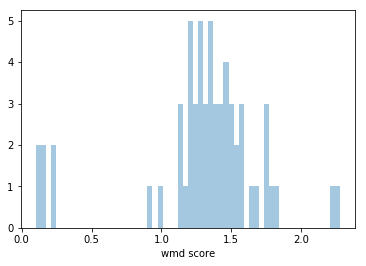

In [46]:
sns.distplot(df['wmd score'], bins = 60, kde=False)

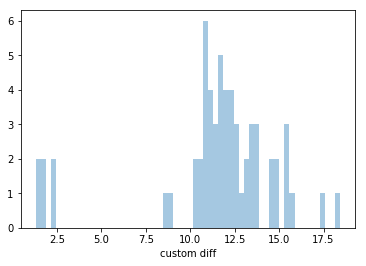

In [47]:
sns.distplot(df['custom diff'], bins = 60, kde=False)

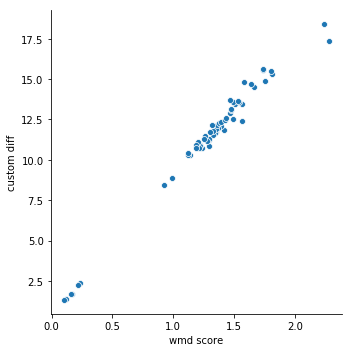

In [48]:
sns.relplot(x="wmd score", y="custom diff",
            #hue="languages pipeline",
            data=df);

На следующих цепочках и останавлю выбор:

In [49]:
df.loc[(df['wmd score'] <= 1.25) & (df['custom diff'] >= 10)].sort_values(by='wmd score')

,languages pipeline,uniqueness,bigrams weight,wmd score,custom diff,uniqueness rank,bigrams weight rank,wmd score rank,custom diff rank,harmonic mean,top
53,russian -> spanish -> russian,61.000000,751621.666667,1.118699,10.452074,49,48,9,50,15.254237,44
47,russian -> portuguese -> russian,60.333333,768345.333333,1.121468,10.290069,50,55,10,52,16.774194,42
46,russian -> portuguese -> english -> russian,59.500000,762659.333333,1.137200,10.309155,51,52,11,51,18.096774,39
15,russian -> dutch -> russian,65.333333,763505.666667,1.188946,10.750344,42,53,12,47,19.118644,38
33,russian -> italian -> russian,61.666667,725525.833333,1.190910,10.920258,48,39,13,44,20.070175,36
48,russian -> portuguese -> russian -> portuguese -> russian,64.833333,771388.833333,1.205856,11.084083,44,56,14,42,21.000000,34
45,russian -> polish -> russian,71.500000,741557.333333,1.215685,10.715323,29,46,15,49,22.968750,31
40,russian -> macedonian -> russian,63.500000,700851.333333,1.224467,10.835588,47,29,16,45,23.606557,30
54,russian -> swedish -> russian,64.666667,724711.166667,1.224491,10.927973,45,38,17,43,24.366667,27
13,russian -> danish -> russian,59.500000,657906.166667,1.237693,10.738065,51,11,18,48,26.181818,21


In [51]:
df

,languages pipeline,uniqueness,bigrams weight,wmd score,custom diff,uniqueness rank,bigrams weight rank,wmd score rank,custom diff rank,harmonic mean,top
28,russian -> greek -> russian,70.500000,703507.500000,1.418145,11.867719,31,30,37,31,33.735294,1
11,russian -> croatian -> russian,70.500000,724063.333333,1.349050,11.710472,31,37,30,34,31.875000,2
31,russian -> indonesian -> russian,69.666667,733926.333333,1.346101,11.651905,33,43,29,35,31.718750,3
51,russian -> slovak -> russian,71.833333,676721.333333,1.331355,11.518705,27,19,28,36,31.500000,4
19,russian -> esperanto -> russian,79.000000,738037.166667,1.564490,12.396873,13,45,49,23,31.305556,5
32,russian -> italian -> danish -> russian,69.666667,714681.166667,1.390936,12.123164,33,35,35,28,31.111111,6
52,russian -> slovenian -> russian,75.833333,732176.166667,1.367986,11.975921,16,42,33,29,30.870968,7
38,russian -> latvian -> russian,71.666667,657184.666667,1.354572,11.931883,28,9,31,30,30.491803,8
12,russian -> czech -> russian,67.666667,711122.833333,1.295563,11.205013,37,34,24,40,30.000000,9
50,russian -> serbian -> russian,65.333333,664475.000000,1.290682,10.828320,42,14,22,46,29.764706,10


## 11. Записываю в файл

In [52]:
df.round(3).to_csv('stats', sep='\t', index=False, encoding='utf-8')